In [38]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

# display image
def display_image(image, title='Image'):
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def binarize_image(image):
	_, binarized = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
	return binarized


def crop_to_bounding_box(image, padding=10):
    # Invert the grayscale image to make black pixels white (255)
    inverted_gray = cv2.bitwise_not(image)

    # Apply a binary threshold to the inverted grayscale image
    _, binary = cv2.threshold(inverted_gray, 1, 255, cv2.THRESH_BINARY)

    # Find coordinates of all non-zero pixels
    coords = np.column_stack(np.where(binary > 0))

    # Get the bounding box coordinates
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # Crop the bounding box from the original image
    cropped_image = image[x_min:x_max, y_min:y_max]
    # cropped_image = image[x_min - padding:x_max + padding, y_min - padding:y_max + padding]

    # pad image
    padded_image = cv2.copyMakeBorder(cropped_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=255)

    return padded_image


# count disconnected components
def disconnected_components(image):
	# Invert the image to make black pixels white (255)
	inverted = cv2.bitwise_not(image)

	# Find connected components
	num_labels, labels = cv2.connectedComponents(inverted)

	# show connected components
	image_with_components = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
	from matplotlib.cm import Set1 as color_map
	for label in range(1, num_labels):
		image_with_components[labels == label] = np.array(color_map(label)[:3]) * 255
	# display_image(image_with_components, title='Disconnected Components')

	return num_labels - 1

def perimetric_complexity(image):
    # Invert the image to make black pixels white (255)
    image = cv2.bitwise_not(image)

    # Find the contours of the character (foreground)
    contours, _ = cv2.findContours(image, cv2.RETR_LIST,
                                   cv2.CHAIN_APPROX_SIMPLE)

    # print(f'Number of contours: {len(contours)}')

    image_with_contours = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) * 0

    # Highlight the skeleton with different colors
    from matplotlib.cm import Set1 as color_map
    for i, contour in enumerate(contours):
        color = np.array(color_map(i)[:3]) * 255
        cv2.drawContours(image_with_contours, [contour], -1, color, 3)

    # display_image(image_with_contours, title='Contours')

    # Calculate the perimeter (P) of the character
    perimeter = 0
    for contour in contours:
        perimeter += cv2.arcLength(contour, True)

    # Calculate the area (A) of the character
    # area = 0
    # for contour in contours:
    #     area += cv2.contourArea(contour)

    area = np.sum(image == 255)

    # print(f'Area: {area:.2f} sq. px')
    # print(f'Perimeter: {perimeter:.2f} px')

    # Calculate the Perimetric Complexity (PC)
    if area != 0:
        perimetric_complexity = (perimeter**2) / (area * 4 * np.pi)
    else:
        perimetric_complexity = float('inf')

    return perimetric_complexity


In [39]:
import pandas as pd
from tqdm import tqdm

In [40]:
TELUGU_FONT = './fonts/NotoSansTelugu-Regular.ttf'
# TELUGU_FONT = './fonts/NATS.ttf'
ENGLISH_FONT = './fonts/NotoSans-Regular.ttf'

In [41]:
def generate_image(string):
	font = ImageFont.truetype(TELUGU_FONT, 250)
	# font = ImageFont.truetype(ENGLISH_FONT, 250)
	
	image = Image.new('RGB', (500, 500), 'white')
	draw = ImageDraw.Draw(image)
	draw.text((0, 0), string, (0, 0, 0), font=font)
	# image.save(os.path.join(folder, f'image_{string}.png'))
	# plt.axis('off')
	# plt.imshow(image)
	# plt.show()

	return image

In [42]:
import concurrent.futures

In [43]:
words = [
    "చుట్టూ", "స్వయం", "చేసి", "అను", "ఇదే", "ప్రతి", "నేను", "వ్యాధి",
    "ముఖ్య", "ఎన్ని", "చర్య", "బోర్డు", "మత", "కళ్లు", "పెళ్లి", "హిందీ",
    "కాలం", "విని", "పెద్ద", "స్థితి", "ఎత్తు", "ఆమె", "రాజు", "త్యాగం",
    "కానీ", "నిన్ను", "అంటూ", "ఐదు", "గ్రహం", "పద", "మూడు", "పడి", "వ్యాప్తి",
    "బట్టి", "ఇట్టి", "బంతి", "రెండు", "పూర్వం", "నువ్వు", "డబ్బు", "రక్తం",
    "తమ", "అంటే", "ఇంట్లో", "ఒక్క", "నుంచి", "పేర్లు", "చూసి", "ఇది", "నన్ను",
    "మొక్క", "ఖర్చు", "ప్రాయం", "పేజీ", "కింది", "వ్యక్తి", "మైనా", "మార్చి",
    "పని", "భార్య", "వ్రాత", "క్రమం", "చెంది", "ఏంటో", "మార్పు", "గదా", "భర్త",
    "తల", "అంత", "వేల", "పంట", "అందు", "ఇక", "ఆట", "చూస్తే", "వద్ద", "శ్రమ",
    "ములు", "సరి", "చాలా", "అది", "భాగం", "తప్పు", "గాలి", "వాడు", "యొక్క",
    "పేరు", "నాకు", "కళ", "అన్నీ", "ఏది", "అతి", "పన్ను", "మంది", "మాట",
    "దృష్టి", "ఉంటే", "ఎలా", "ఆయా", "కొని", "మీరు", "ఉండి", "వృద్ధి", "జ్ఞానం",
    "మధ్య", "పెట్టి", "అనే", "వేరు", "నీకు", "వాడి", "శాంతి", "కవి", "మన",
    "నది", "మని", "ఒక", "ఇంత", "ప్రేమ", "వంట", "శబ్దం", "రెండో", "ప్రాంతం",
    "కూడా", "దూరం", "శతం", "విద్య", "మీకు", "సార్లు", "క్రింది", "పూర్తి",
    "అలా", "బాగా", "క్రొత్త", "స్పష్టం", "మాత్రం", "ఆరు", "ఎంత", "గుండె",
    "పాత్ర", "పటం", "ప్రశ్న", "మందు", "మూల", "ఇచ్చి", "వచ్చే", "కాదు", "ఇంకా",
    "ధర", "తన", "వచ్చి", "ఇవి", "కొత్త", "పట్ల", "ఏదో", "ఇంటి", "సమ", "గత",
    "పాపం", "లేక", "ప్రభ", "తూర్పు", "అదే", "అవి", "కాంతి", "ఒకే", "అని",
    "గూర్చి", "ఇలా", "చెప్పు", "వలె", "ద్వారా", "ఇంకో", "అటు", "శక్తి", "ఏమి",
    "కంటే", "ముందు", "న్యాయం", "ప్రాప్తి", "గొప్ప", "తల్లి", "కల", "అమ్మ",
    "జిల్లా", "చిన్న", "కొంత", "ఉంది", "ముందే", "కాస్త", "తను", "లేవు",
    "వాళ్లు", "ఇట్లు", "వస్తే", "దాన్ని", "పది", "ఇల్లు", "రంగు"
]

In [44]:
from main3 import *

syllabify(words[0])

syllables_all = []
for word in words:
	for syllable in syllabify(word):
		syllables_all.append(syllable)

syllables_all = list(set(syllables_all))
print(len(syllables_all))
syllables_all[:10]

200


['చెం', 'డ', 'చ్చే', 'బ్బు', 'క్తి', 'ద్య', 'స', 'దో', 'ర్డు', 'పం']

In [45]:
wordlist = syllables_all

In [46]:

# def process_word(word):
#     """Process a single word to get graphical complexities."""
#     image = generate_image(word)
#     image = np.array(image)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     image = binarize_image(image)
#     image = crop_to_bounding_box(image)
#     pc = perimetric_complexity(image)
#     dc = disconnected_components(image)
#     return (word, dc, pc)

# words_measures = []

# # Using ThreadPoolExecutor to process words in parallel
# with concurrent.futures.ThreadPoolExecutor() as executor:
#     futures = [executor.submit(process_word, word) for word in wordlist]
#     for future in tqdm(concurrent.futures.as_completed(futures), total=len(wordlist)):
#         words_measures.append(future.result())

# # Create DataFrame and save results
# df = pd.DataFrame(words_measures, columns=['akshara', 'dc', 'pc'])
# # df.to_csv('200_aksharas_gc_automatic.csv', index=False)

# # sort
# df = df.sort_values(by='akshara')
# df

In [47]:
# df = pd.read_csv('200_aksharas_gc_automatic.csv')
# df.head()

In [48]:
# # combine with manual sf and cp

# df_manual = pd.read_csv('200_aksharas_sf_cp_manual.csv')
# df_manual.head()

In [49]:
# # merge
# df = pd.merge(df, df_manual, on='akshara')
# display(df.head())
# df.to_csv('200_aksharas_gc.csv', index=False)

In [50]:
df = pd.read_csv('200_aksharas_gc.csv')
df.head()

,akshara,dc,pc,sf,cp
0,డ,1,10.521497,4,3
1,స,2,9.561270,2,0
2,చ్చే,2,20.757524,8,6
3,చెం,2,15.728317,5,3
4,బ్బు,2,23.086078,5,3


In [51]:
import matplotlib.font_manager as fm
telugu_prop = fm.FontProperties(fname=TELUGU_FONT)
english_prop = fm.FontProperties(fname=ENGLISH_FONT)
# global font
plt.rcParams['font.family'] = [english_prop.get_name(), telugu_prop.get_name()]

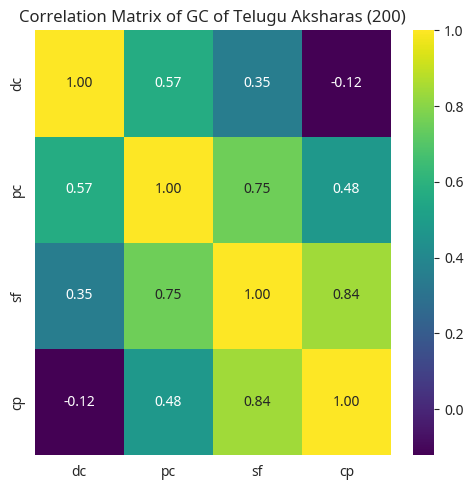

In [52]:
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(5, 5))
sns.heatmap(df[['dc', 'pc', 'sf', 'cp']].corr(), annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of GC of Telugu Aksharas (200)')
plt.tight_layout()
plt.show()

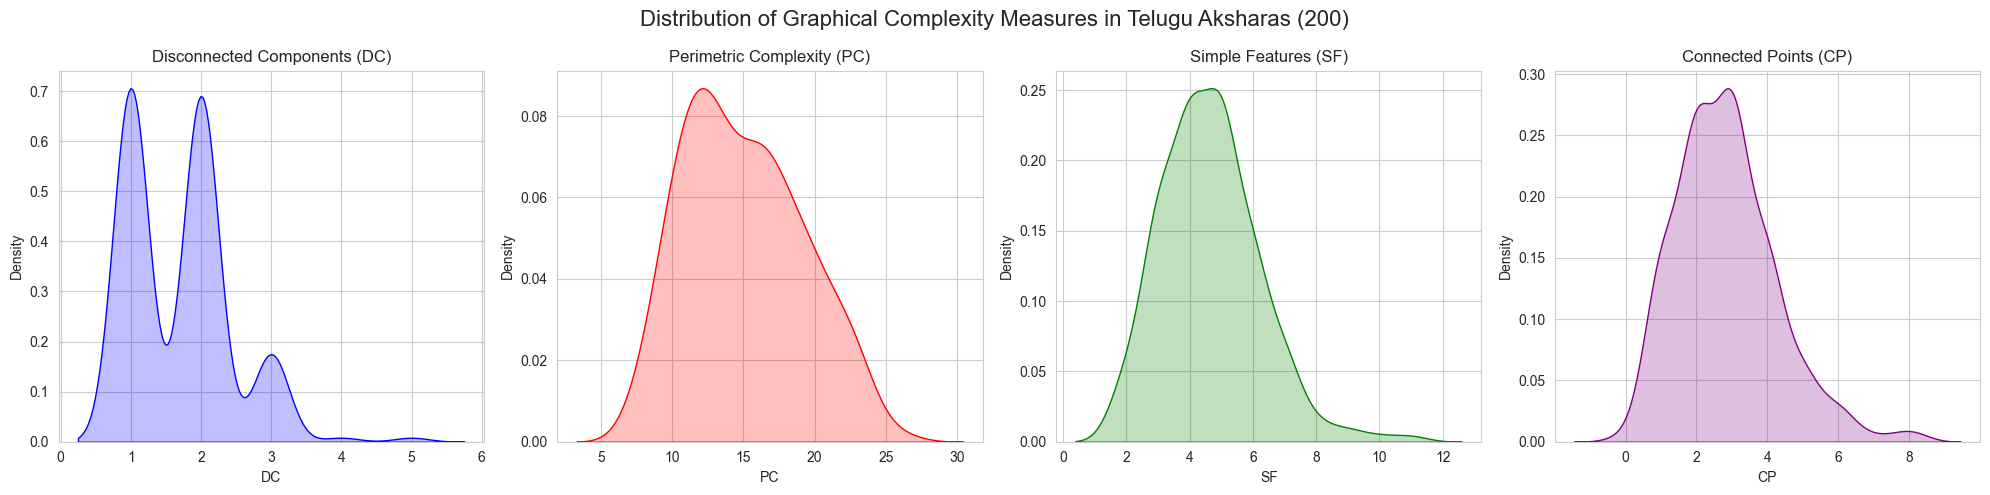

In [53]:
# plot all distributions as KDE

sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

sns.kdeplot(df['dc'], ax=ax[0], color='blue', fill=True)
ax[0].set_title('Disconnected Components (DC)')
ax[0].set_xlabel('DC')

sns.kdeplot(df['pc'], ax=ax[1], color='red', fill=True)
ax[1].set_title('Perimetric Complexity (PC)')
ax[1].set_xlabel('PC')

sns.kdeplot(df['sf'], ax=ax[2], color='green', fill=True)
ax[2].set_title('Simple Features (SF)')
ax[2].set_xlabel('SF')

sns.kdeplot(df['cp'], ax=ax[3], color='purple', fill=True)
ax[3].set_title('Connected Points (CP)')
ax[3].set_xlabel('CP')

plt.suptitle('Distribution of Graphical Complexity Measures in Telugu Aksharas (200)', fontsize=16)
plt.tight_layout()
plt.show()


In [54]:
# print statistics

df.describe()

,dc,pc,sf,cp
count,200.000000,200.000000,200.000000,200.000000
mean,1.690000,15.029923,4.640000,2.830000
std,0.725626,4.131514,1.546726,1.393127
min,1.000000,7.606289,2.000000,0.000000
25%,1.000000,11.648221,4.000000,2.000000
50%,2.000000,14.667810,5.000000,3.000000
75%,2.000000,18.039893,5.250000,4.000000
max,5.000000,26.109962,11.000000,8.000000
